In [144]:
import cv2
import numpy as np
from skimage.segmentation import slic
from PIL import Image
from math import sqrt, floor, ceil, nan, pi
from skimage.transform import rotate
import matplotlib.pyplot as plt
from skimage.io import imread
import os
from skimage.color import rgb2hsv
from scipy.stats import circmean, circvar, circstd

imgDir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, "data"))

In [145]:
#not my functions but needed to run my functions;

def find_midpoint_v1(image):
    
    row_mid = image.shape[0] / 2     # nr of the middle row
    col_mid = image.shape[1] / 2     # nr of the middle column
    return row_mid, col_mid

def asymmetry(mask):
    

    row_mid, col_mid = find_midpoint_v1(mask)           # uses the previous function

    # slicing into 4 different halves. We will calculate symmetry on both halves
    # ceil and floor are used in case the outputs of the midpoint functions have decimals
    upper_half = mask[:ceil(row_mid), :]
    lower_half = mask[floor(row_mid):, :]
    left_half = mask[:, :ceil(col_mid)]
    right_half = mask[:, floor(col_mid):]

    # flip one of the complementary halves of each pair (one horizontal half, one vertical half)
    flipped_lower = np.flip(lower_half, axis=0)
    flipped_right = np.flip(right_half, axis=1)

    # using the xor logic, makes a binary array of all pixels in both symmetry pairs
    hori_xor_area = np.logical_xor(upper_half, flipped_lower)
    vert_xor_area = np.logical_xor(left_half, flipped_right)

    # to calculate ratio, we need to know how many pixels there are in total
    total_pxls = np.sum(mask)
    # the sum together how many true values there are
    # keeping note of xor logic => the more ASYMMETRY the higher the number
    hori_asymmetry_pxls = np.sum(hori_xor_area)
    vert_asymmetry_pxls = np.sum(vert_xor_area)

    asymmetry_score = (hori_asymmetry_pxls + vert_asymmetry_pxls) / (total_pxls * 2)

    return round(asymmetry_score, 4)

def cut_mask(mask):
    
    # input is numpy array mask
    col_sums = np.sum(mask, axis=0)     # sums up the values between 0 and 1
    row_sums = np.sum(mask, axis=1)     # shows if any row or column contains anything but 0s

    active_cols = []        # lists all the columns where there is no lesion
    for index, col_sum in enumerate(col_sums):  # takes all columns
        if col_sum != 0:                        # if the full column is 0, it's not added to the list
            active_cols.append(index)

    active_rows = []        # analog for rows
    for index, row_sum in enumerate(row_sums):
        if row_sum != 0:
            active_rows.append(index)

    # taking the bordering rows and columns of the mask (excluding the black edges where there is nothing)
    col_min = active_cols[0]
    col_max = active_cols[-1]
    row_min = active_rows[0]
    row_max = active_rows[-1]

    # saving the new mask
    cut_mask_ = mask[row_min:row_max+1, col_min:col_max+1]

    return cut_mask_



def rotation_asymmetry(mask, n: int):

    asymmetry_scores = {}

    for i in range(n):

        degrees = 90 * i / n

        rotated_mask = rotate(mask, degrees)
        cutted_mask = cut_mask(rotated_mask)

        asymmetry_scores[degrees] = asymmetry(cutted_mask)

    return asymmetry_scores

In [146]:
#asymmetry functions; mean, best, worst asymmetry
def mean_asymmetry(mask, rotations = 30):
    
    asymmetry_scores = rotation_asymmetry(mask, rotations) #
    mean_score = sum(asymmetry_scores.values()) / len(asymmetry_scores)

    return mean_score          

def best_asymmetry(mask, rotations = 30):
    
    asymmetry_scores = rotation_asymmetry(mask, rotations)
    best_score = min(asymmetry_scores.values())

    return best_score

def worst_asymmetry(mask, rotations = 30):
    
    asymmetry_scores = rotation_asymmetry(mask, rotations)
    worst_score = max(asymmetry_scores.values())

    return worst_score

Asymmetry Functions

In [147]:
#The mean asymmetry function;
#Input is a np.array for the following 2 as well
for i in range(9):
    mask_path = os.path.join(imgDir,"maskTest",f"mask{i}.png") 
    img = Image.open(mask_path).convert("L") #convert to grayscale for the cutmask function to work (removes one demension from the matrix)
    mask_array = np.array(img) #converts PIL image into np.array
    print(f"The mean asymmetry for mask {i} is {mean_asymmetry(mask_array)}")

The mean asymmetry for mask 0 is 0.4978200000000001
The mean asymmetry for mask 1 is 0.0013599999999999999
The mean asymmetry for mask 2 is 0.5512199999999999
The mean asymmetry for mask 3 is 0.4215600000000001
The mean asymmetry for mask 4 is 0.5348633333333335
The mean asymmetry for mask 5 is 0.8304366666666667
The mean asymmetry for mask 6 is 0.8304366666666667
The mean asymmetry for mask 7 is 0.044033333333333334
The mean asymmetry for mask 8 is 0.26701


In [148]:
#the best (lowest) asymmetry function;
mask_path_circle = os.path.join(imgDir,"maskTest","mask1.png")
img_circle = Image.open(mask_path_circle).convert("L") #convert to grayscale for the cutmask function to work (removes one demension from the matrix)
circle_array = np.array(img_circle) #converts PIL image into np.array
best_asymmetry(circle_array) #should return a value very close to 0 or 0 for a perfect circle

0.0

In [149]:
#the worst (highest) asymmetry function;
mask_path_weird = os.path.join(imgDir,"maskTest","mask4.png")
img_weird = Image.open(mask_path_weird).convert("L") #convert to grayscale for the cutmask function to work (removes one demension from the matrix)
weird_array = np.array(img_weird) #converts PIL image into np.array
worst_asymmetry(weird_array) #should return a value close to 1 for the weird shape in mask4.png

#the returned value is about 0.6 

0.5977

In [150]:
#Fun Observation for mask 6 and 7

Slic Segmentation
Input: image, mask, n_segments = 50, compactness=0.1

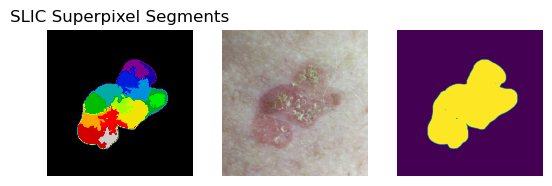

In [151]:
def slic_segmentation(image, mask, n_segments = 50, compactness = 0.1):
    
    slic_segments = slic(image,
                    n_segments = n_segments,
                    compactness = compactness,
                    sigma = 1,
                    mask = mask,
                    start_label = 1,
                    channel_axis = 2)
    
    return slic_segments

img1 = os.path.join(imgDir,"MaskImagePair","PAT_76_1039_269.png")
img1_mask_path = os.path.join(imgDir,"MaskImagePair","PAT_76_1039_269_mask.png")
img1_array = np.array(Image.open(img1))
img1_mask_array = np.array(Image.open(img1_mask_path))

segments = slic_segmentation(img1_array,img1_mask_array,15)

plt.subplot(1,3,1)
plt.imshow(segments, cmap='nipy_spectral')  
plt.title("SLIC Superpixel Segments")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img1_array)
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img1_mask_array)
plt.axis("off")
plt.show()

In [152]:
#Get rgb means functions
def get_rgb_means(image, slic_segments):
    
    max_segment_id = np.unique(slic_segments)[-1]

    rgb_means = []
    for i in range(1, max_segment_id + 1):

        segment = image.copy()
        segment[slic_segments != i] = -1

        rgb_mean = np.mean(segment, axis = (0, 1), where = (segment != -1))
        
        rgb_means.append(rgb_mean) 
        
    return rgb_means

get_rgb_means(img1_array,segments)

C:\Users\khatt\AppData\Local\Temp\ipykernel_6512\1961485323.py:10: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  segment[slic_segments != i] = -1


[array([253.73461162, 253.54582292, 253.34282455, 255.        ]),
 array([254.38905667, 254.30971573, 254.24227413, 255.        ]),
 array([253.12045989, 252.71970306, 252.52211841, 255.        ]),
 array([253.57909107, 253.27514756, 253.15485425, 255.        ]),
 array([252.85925765, 252.23434003, 252.19949665, 255.        ]),
 array([254.03361217, 253.86471845, 253.79664313, 255.        ]),
 array([252.84875973, 252.22676444, 252.17557487, 255.        ]),
 array([254.18459895, 253.94794496, 253.88010139, 255.        ]),
 array([253.72975557, 253.40287887, 253.36964331, 255.        ]),
 array([252.78795582, 252.28085461, 252.15976462, 255.        ]),
 array([253.35102662, 252.74767337, 252.78140503, 255.        ]),
 array([253.2755966 , 252.71254391, 252.79473475, 255.        ]),
 array([253.0858881 , 252.35315227, 252.37222524, 255.        ]),
 array([254.02777838, 253.73872895, 253.74597139, 255.        ])]

In [ ]:
#get hsv mean
def get_hsv_means(image, slic_segments):
    
    img_rgb = img1_array[:, :, :3]  # added by me as original image was RGBA format
    hsv_image = rgb2hsv(img_rgb)

    max_segment_id = np.unique(slic_segments)[-1]

    hsv_means = []
    for i in range(1, max_segment_id + 1):

        segment = hsv_image.copy()
        segment[slic_segments != i] = nan

        hue_mean = circmean(segment[:, :, 0], high=1, low=0, nan_policy='omit') 
        sat_mean = np.mean(segment[:, :, 1], where = (slic_segments == i))  
        val_mean = np.mean(segment[:, :, 2], where = (slic_segments == i)) 

        hsv_mean = np.asarray([hue_mean, sat_mean, val_mean])

        hsv_means.append(hsv_mean)
        
    return hsv_means

get_hsv_means(img1_array,segments)

[array([0.08548571, 0.1906142 , 0.62850629]),
 array([0.08221066, 0.11548708, 0.6792747 ]),
 array([0.05659754, 0.2351726 , 0.58287246]),
 array([0.04781338, 0.16878678, 0.64343583]),
 array([0.00810728, 0.27026319, 0.55429687]),
 array([0.05373452, 0.11683682, 0.6818159 ]),
 array([0.01217164, 0.33099771, 0.49704951]),
 array([0.03648991, 0.22511859, 0.62630919]),
 array([0.02996938, 0.20676092, 0.604533  ]),
 array([0.04061545, 0.17730893, 0.63102018]),
 array([0.99259165, 0.25983555, 0.58958725]),
 array([0.97447709, 0.20296675, 0.62083567]),
 array([0.99632629, 0.24860446, 0.61370283]),
 array([5.12644021e-04, 1.67346114e-01, 6.60860872e-01])]